# Hilbert-Schmidt Independence Criterion (HSIC)

In [51]:
import sys
sys.path.append("../../../")

import objax
import jax
import jax.numpy as np

from jaxkern.kernels.stationary import RBF
from jaxkern.kernels.linear import Linear
from jaxkern.similarity.mmd import MMD, MMD_RBF, MMD_PXPY, MMD_PXPY_RBF
from jaxkern.kernels.sigma import estimate_sigma_median
from jaxkern.kernels.utils import centering

from jaxkern.data.similarity import generate_data

# 
import numpy as onp

# MATPLOTLIB Settings
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


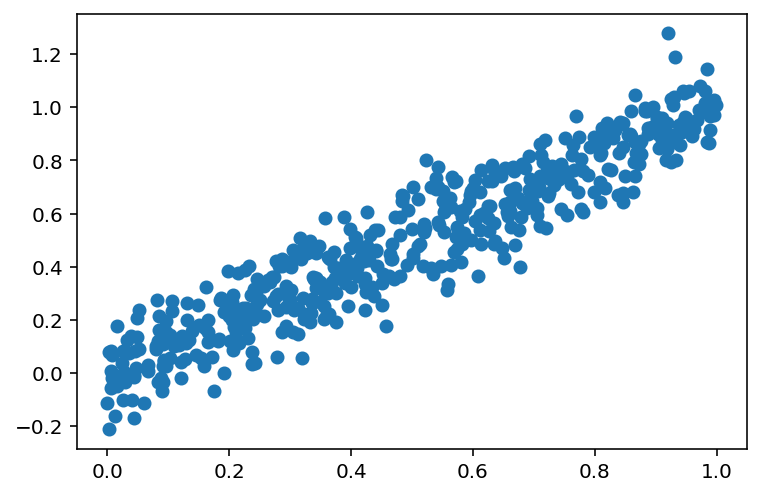

In [26]:
from scipy import stats
# random state
seed = 123
rng = onp.random.RandomState(seed)

# generate fake data
n_samples = 500
noise_y = 0.1

X, Y = generate_data(n_samples, "linear", noise_y=noise_y)

# X = stats.norm.rvs(size=(n_samples, 1))
# Y = stats.norm.rvs(size=(n_samples, 1))

X = np.array(X)
Y = np.array(Y)

plt.scatter(X, Y)

## MMD - From Scratch

#### 1. Calculate Kernel Matrices

In [27]:
from jaxkern.kernels.linear import Linear

# initialize kernel
lin_kern = Linear()

# calculate kernel matrices
K_x = lin_kern(X, X)
K_y = lin_kern(Y, Y)

In [65]:
np.einsum("ij,ij->", K_x, K_y)

DeviceArray(26747.736, dtype=float32)

In [66]:
np.einsum("ij,kl->", K_x, K_y)

DeviceArray(3.732351e+09, dtype=float32)

In [67]:
np.einsum("ij,ik->", K_x, K_y)

DeviceArray(9991677., dtype=float32)

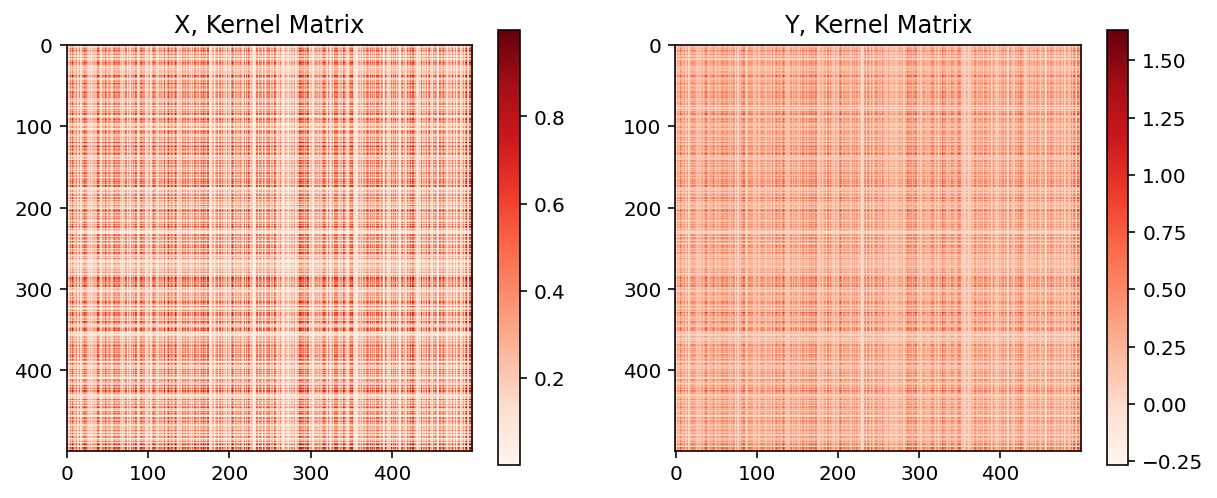

In [28]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
pts1 = ax[0].imshow(K_x, cmap='Reds')
ax[0].set_title("X, Kernel Matrix")
fig.colorbar(pts1, ax=ax[0])
pts2 = ax[1].imshow(K_y, cmap='Reds')
fig.colorbar(pts2, ax=ax[1])
ax[1].set_title("Y, Kernel Matrix")
plt.show()

#### 3. Summarize: HSIC Norm

Here we implement the HSIC norm which is a way to summarize the information with the matrices.

$$
\text{HSIC}(\mathbf{X}, \mathbf{Y}) = \langle \tilde{K}_x, \tilde{K}_y \rangle_{\text{HS}}
$$

In [29]:
# get the expectrations
A = np.mean(K_x * K_y)
B = np.mean(np.mean(K_x, axis=0) * np.mean(K_y, axis=0))
C = np.mean(K_x) * np.mean(K_y)

mmd_value = A - 2 * B + C

# scaling term

print(f"MMD (PxPy): {mmd_value:.4f}")

MMD (PxPy): 0.0068


### Alternative

### Linear Kernel

In [30]:
kernel = Linear()

mmd_clf = MMD(kernel, kernel, kernel, bias=False)

mmd_val = mmd_clf(X, Y)


print(f"MMD: {mmd_val:.4f}")
# calculate hsic value

MMD: 0.6969


### RBF Kernel

In [31]:
# estimate sigma
σ_x = estimate_sigma_median(X, X)
σ_y = estimate_sigma_median(Y, Y)
σ_xy = estimate_sigma_median(X, Y)

print(f"σ_x: {σ_x:.4f}" )
print(f"σ_y: {σ_y:.4f}" )

# calculate kernel matrices
kernel_X = RBF(variance=1.0, length_scale=σ_x)
kernel_Y = RBF(variance=1.0, length_scale=σ_y)
kernel_XY = RBF(variance=1.0, length_scale=σ_xy)

σ_x: 0.0838
σ_y: 0.0945


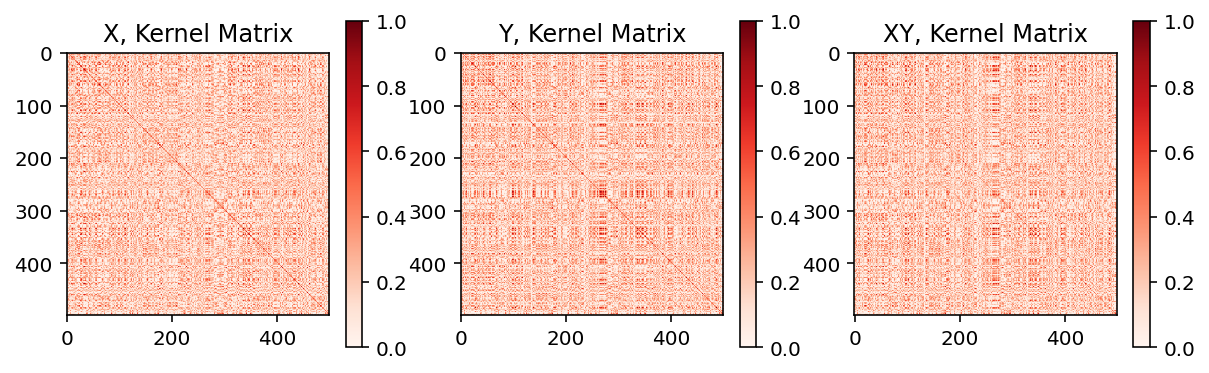

In [32]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10, 3))
pts1 = ax[0].imshow(kernel_X(X,X), cmap='Reds')
ax[0].set_title("X, Kernel Matrix")
fig.colorbar(pts1, ax=ax[0])
pts2 = ax[1].imshow(kernel_Y(Y, Y), cmap='Reds')
fig.colorbar(pts2, ax=ax[1])
ax[1].set_title("Y, Kernel Matrix")
pts3 = ax[2].imshow(kernel_XY(X, Y), cmap='Reds')
fig.colorbar(pts3, ax=ax[2])
ax[2].set_title("XY, Kernel Matrix")
plt.show()

In [33]:
# initialize HSIC model
mmd_clf = MMD(kernel_X, kernel_Y, kernel_XY, bias=True)

# calculate HSIC
mmd_val = mmd_clf(X, Y)
print(f"MMD: {mmd_val:.4f}")

MMD: 0.0295


#### Convenience Function

Let's be honest, most people are going to use the RBF kernel. It's universal, quick n dirty, and quite simple to interpretate. So I made a convenience function to help people deal with it.

In [34]:
sigma_f = estimate_sigma_median

nhsic_clf = MMD_PXPY_RBF(sigma_f, sigma_f, sigma_f)

nhsic_value = nhsic_clf(X, Y)

print(f"HSIC: {nhsic_value:.4f}")

HSIC: 0.0554


In [35]:
sigma_f = estimate_sigma_median

nhsic_clf = MMD_RBF(sigma_f, sigma_f, sigma_f, center=False, bias=False)

nhsic_value = nhsic_clf(X, Y)

print(f"MMD: {nhsic_value:.4f}")

MMD: 0.6315


## Other Datasets

### Non-Linear

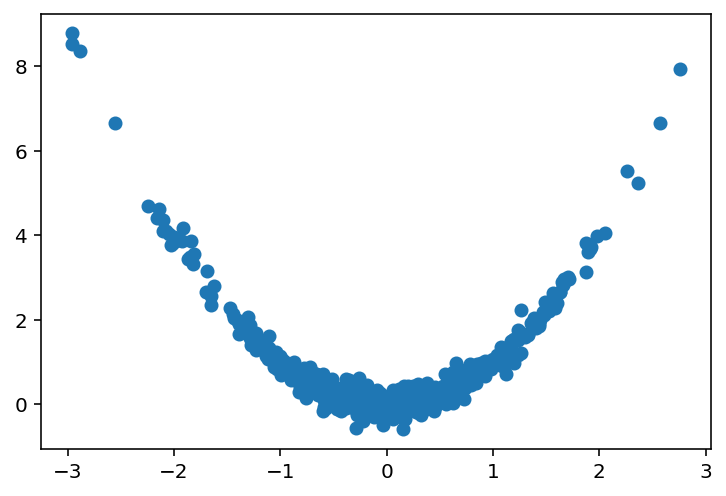

In [36]:
X = onp.random.randn(n_samples, 1)
Y = X**2 + 0.2 * onp.random.randn(X.shape[0], X.shape[1])

plt.scatter(X, Y)

#### Linear Kernel

In [37]:
# initialize HSIC model
kernel = Linear()
nhsic_clf = MMD(kernel, kernel, kernel, bias=False)

# calculate HSIC
nhsic_val = nhsic_clf(X, Y)

print(f"nHSIC (Linear): {nhsic_val:.4f}")

nHSIC (Linear): 0.9154


#### RBF Kernel

In [38]:
# estimate sigma
sigma_f = estimate_sigma_median

# initialize HSIC model
nhsic_clf = MMD_RBF(sigma_f, sigma_f, sigma_f, bias=False)

# calculate HSIC
nhsic_val = nhsic_clf(X, Y)

print(f"nHSIC (RBF): {nhsic_val:.4f}")

nHSIC (RBF): 0.9831


### Periodic

In [39]:
X = np.abs(2 * onp.random.randn(n_samples, 1))
Y = np.sin(X) + 0.2 * onp.random.randn(X.shape[0], X.shape[1])

#### Linear Kernel

In [40]:
# initialize HSIC model
kernel = Linear()
nhsic_clf = MMD(kernel, kernel, kernel, bias=False)

# calculate HSIC
nhsic_val = nhsic_clf(X, Y)

print(f"nHSIC (Linear): {nhsic_val:.4f}")

nHSIC (Linear): 1.6638


#### RBF Kernel

In [41]:
# estimate sigma
sigma_f = estimate_sigma_median

# initialize HSIC model
nhsic_clf = MMD_RBF(sigma_f, sigma_f, sigma_f, bias=False)

# calculate HSIC
nhsic_val = nhsic_clf(X, Y)

print(f"nHSIC (RBF): {nhsic_val:.4f}")

nHSIC (RBF): 0.9243


### Circle

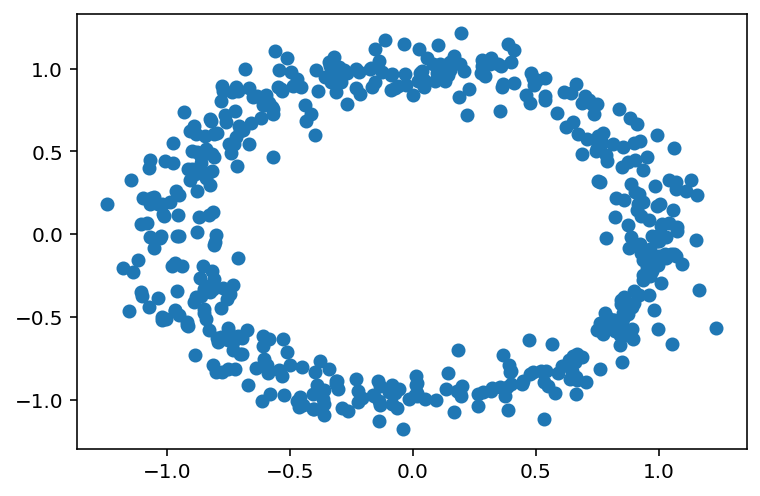

In [42]:
X, Y = generate_data(n_samples, "circle", noise_y=0.1, noise_x=0.1)

plt.scatter(X, Y)

#### Linear Kernel

In [43]:
# initialize HSIC model
kernel = Linear()
nhsic_clf = MMD(kernel, kernel, kernel, bias=False)

# calculate HSIC
nhsic_val = nhsic_clf(X, Y)

print(f"nHSIC (Linear): {nhsic_val:.4f}")

nHSIC (Linear): 0.0000


#### RBF Kernel

In [44]:
# estimate sigma
sigma_f = estimate_sigma_median

# initialize HSIC model
nhsic_clf = MMD_RBF(sigma_f, sigma_f, sigma_f, bias=False)

# calculate HSIC
nhsic_val = nhsic_clf(X, Y)

print(f"nHSIC (RBF): {nhsic_val:.4f}")

nHSIC (RBF): 0.9455


### Random

In [45]:
X, Y = generate_data(n_samples, "random", noise_y=noise_y)

#### Linear Kernel

In [46]:
# initialize HSIC model
kernel = Linear()
nhsic_clf = MMD(kernel, kernel, kernel, bias=False)

# calculate HSIC
nhsic_val = nhsic_clf(X, Y)

print(f"nHSIC (Linear): {nhsic_val:.4f}")

nHSIC (Linear): 0.7041


#### RBF Kernel

In [47]:
# estimate sigma
sigma_f = estimate_sigma_median

# initialize HSIC model
nhsic_clf = MMD_RBF(sigma_f, sigma_f, sigma_f, bias=False)

# calculate HSIC
nhsic_val = nhsic_clf(X, Y)

print(f"nHSIC (RBF): {nhsic_val:.4f}")

nHSIC (RBF): 0.6230


## HSIC Equivalent

In [48]:
X, Y = generate_data(n_samples, "linear", noise_y=noise_y)

In [52]:
# linear kernel
K_x = lin_kern(X, X)
K_y = lin_kern(Y, Y)

# center matrices
K_xc = centering(K_x)
K_yc = centering(K_y)

In [63]:
# get the expectrations
hsic_value = 1 / (K_xc.shape[0])**2 * np.sum(K_xc * K_yc)

print(f"HSIC: {hsic_value:.4f}")

HSIC: 0.0068


In [64]:
mmd_value = MMD_PXPY(lin_kern, lin_kern, center=False)(X, Y)

print(f"MMD: {mmd_value:.4f}")

MMD: 0.0068
